In [26]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [15]:
os.getcwd()

'/home/jupyter-st126490/assignment3'

In [16]:
asm1_img = cv2.imread('./data/asm-1.jpg')

In [17]:
asm1_img.shape

(428, 639, 3)

In [19]:
img_rgb = cv2.cvtColor(asm1_img, cv2.COLOR_BGR2RGB)

### Using YOLO for first subtask: Generate a Bounding Box

In [22]:
model = YOLO("yolov8s.pt") 
results = model(img_rgb, conf=0.8)[0]


0: 448x640 1 person, 1 bicycle, 14.4ms
Speed: 2.6ms preprocess, 14.4ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)


In [28]:
person_boxes = []
for box in results.boxes:
    cls = int(box.cls[0])
    if cls == 0:  # class 0 = person
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        person_boxes.append((x1, y1, x2 - x1, y2 - y1))

if len(person_boxes) == 0:
    raise Exception("No person detected in image!")

# choose the largest bounding box
bx, by, bw, bh = max(person_boxes, key=lambda b: b[2] * b[3])
rect = (bx, by, bw, bh)
print("Bounding box:", bx, by, bw, bh)

Bounding box: 261 64 91 236


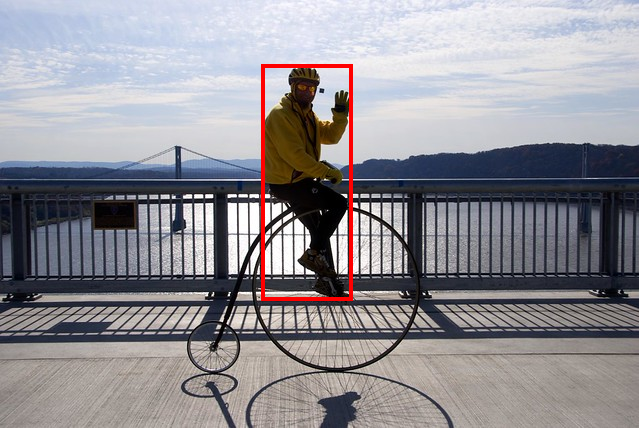

In [38]:
from PIL import Image, ImageDraw

det_img = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(det_img)

draw.rectangle([bx, by, bx+bw, by+bh], outline="red", width=4)

det_img.show() 

# Interactive Foreground Extraction using GrabCut Algorithm
* https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

In [42]:
results_fg = []

mask = np.zeros(img_rgb.shape[:2], np.uint8)
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

cv2.grabCut(img_rgb, mask, rect, bgModel, fgModel, it, cv2.GC_INIT_WITH_RECT)

# convert mask → foreground binary mask
fg_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")

fg_result = img_rgb * fg_mask[:, :, None]
results_fg.append((it, fg_mask, fg_result))

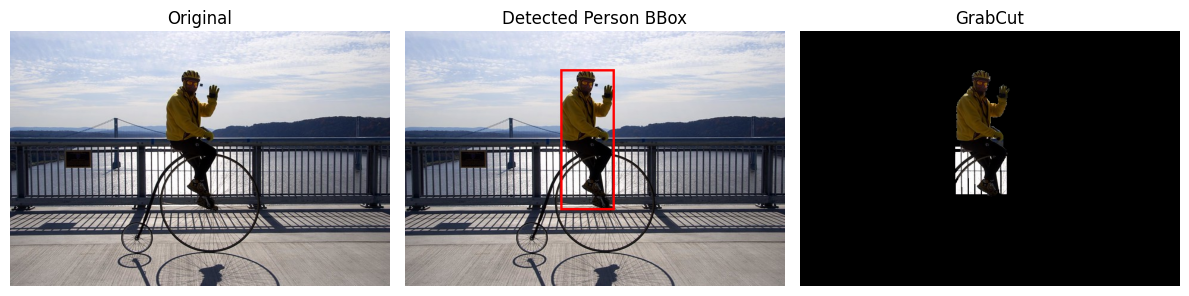

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis('off')
plt.subplot(2, 3, 2); plt.imshow(det_img); plt.title("Detected Person BBox"); plt.axis('off')

idx = 3
for it, fg_mask, fg_img in results_fg:
    plt.subplot(2, 3, idx); plt.imshow(fg_img); plt.title(f"GrabCut"); plt.axis('off')
    idx += 1

plt.tight_layout()
plt.show()